# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-07-21 19:22:35,653 INFO    : root         : Using LISA logging configuration:
2020-07-21 19:22:35,654 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-07-21 19:22:35,928 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-07-21 19:22:35,942 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMTRJR1pVUC9hcXVlZHVjdHMnLCBsYXlvdXQ9TGF5b3V0KHdpZHRoPXUnMjAwJScpLCBzdHlsZT1EZXPigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing 0CAH5_Naver_2019_08_23_07_30_01_1.html - 168313 lines are Ok
Parsing 0CAH5_Naver_2019_08_23_07_30_20_2.html - 190527 lines are Ok
Parsing 9IBA5_Naver_2019_08_23_07_28_19_4.html - 171695 lines are Ok
Parsing 9IBA5_Naver_2019_08_23_07_27_59_3.html - 196891 lines are Ok
Parsing 9IBA5_Naver_2019_08_23_07_27_22_1.html - 166398 lines are Ok
Parsing 9IBA5_Naver_2019_08_23_07_27_41_2.html - 168550 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

Naver_0CAH5_Naver_2019_08_23_07_30_01_1


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1967.0,NaN,9.865,6.335,NaN,NaN,NaN,NaN,NaN
1368.0,NaN,1.090,0.018,NaN,NaN,NaN,NaN,1811.927
21366.0,NaN,626.527,35.833,593.635,299.526,15.062,45.928,NaN
3128.0,1.131,2.173,9.916,NaN,NaN,NaN,NaN,NaN
21465.0,14.822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21471.0,NaN,NaN,NaN,121.341,NaN,8.500,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1967.0,NaN,2414767.780,2414788.232,NaN,NaN,NaN,NaN,NaN
1368.0,NaN,1.209,0.017,NaN,NaN,NaN,NaN,1801.06
21588.0,NaN,654.838,37.514,556.876,290.513,11.877,50.155,NaN
3128.0,1.535,10.194,10.576,NaN,NaN,NaN,NaN,NaN
21688.0,14.671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21692.0,NaN,NaN,NaN,115.447,NaN,11.684,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

Naver_9IBA5_Naver_2019_08_23_07_28_19_4


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
25446.0,15.290,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25350.0,NaN,620.675,55.053,548.344,252.734,10.007,36.802,NaN
25451.0,NaN,NaN,NaN,93.938,NaN,10.134,NaN,NaN
1902.0,NaN,8.201,0.774,NaN,NaN,NaN,NaN,NaN
3535.0,1.851,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680.0,NaN,2.747,1.101,NaN,NaN,NaN,NaN,NaN
1681.0,NaN,0.625,0.532,NaN,NaN,NaN,NaN,NaN
1589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1726.642
3095.0,NaN,0.222,2.192,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
25250.0,15.901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25255.0,NaN,NaN,NaN,90.164,NaN,9.164,NaN,NaN
1902.0,NaN,8.468,0.528,NaN,NaN,NaN,NaN,NaN
3535.0,1.630,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680.0,NaN,3.545,1.528,NaN,NaN,NaN,NaN,NaN
1681.0,NaN,0.637,0.547,NaN,NaN,NaN,NaN,NaN
1589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1924.688
3095.0,NaN,0.257,1.763,NaN,NaN,NaN,NaN,NaN
1822.0,0.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
24847.0,13.223,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902.0,NaN,12.375,4.267,NaN,NaN,NaN,NaN,NaN
3535.0,2.114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680.0,NaN,2.335,1.365,NaN,NaN,NaN,NaN,NaN
1681.0,NaN,0.705,0.466,NaN,NaN,NaN,NaN,NaN
24851.0,NaN,NaN,NaN,98.906,NaN,8.707,NaN,NaN
1589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1786.524
3095.0,NaN,0.221,2.945,NaN,NaN,NaN,NaN,NaN
24751.0,NaN,631.630,51.985,527.763,253.015,47.402,35.48,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1681.0,NaN,0.585,0.481,NaN,NaN,NaN,NaN,NaN
1902.0,NaN,1.146,5.055,NaN,NaN,NaN,NaN,NaN
3535.0,1.558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680.0,NaN,1.720,0.027,NaN,NaN,NaN,NaN,NaN
24945.0,NaN,616.329,51.184,562.032,253.394,12.340,35.76,NaN
25042.0,12.984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1708.908
25046.0,NaN,NaN,NaN,88.251,NaN,9.063,NaN,NaN
3095.0,NaN,0.218,1.737,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

In [18]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  \
                                        pid                        
Naver_0CAH5_Naver_2019_08_23_07_30_01_1 1368.0             1.090   
                                        1368.0             1.209   
Naver_9IBA5_Naver_2019_08_23_07_28_19_4 1589.0               NaN   
                                        1589.0               NaN   
                                        1589.0               NaN   
                                        1589.0               NaN   

                                                Choreographer #1  launching  
                                        pid                                  
Naver_0CAH5_Naver_2019_08_23_07_30_01_1 1368.0             0.018   1811.927  
                                        1368.0             0.017   1801.060  
Naver_9IBA5_Naver_2019_08_23_07_28_19_4 1589.0               NaN   1726.642  
                                        1589.0               NaN   1924.688  
                                        1589.0               NaN   1786.524  
                                        1589.0               NaN   1708.908

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [20]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
Naver_0CAH5_Naver_2019_08_23_07_30_01_1 time                                0   
                                        RUNNING                             0   
                                        RUNNABLE                            0   
                                        SLEEPING                            0   
                                        UNINTERUPTIBLE_SLEEP                0   
                                        UNINTERUPTIBLE_SLEEP(I/O)           0   
Naver_9IBA5_Naver_2019_08_23_07_28_19_4 time                                0   
                                        RUNNING                             0   
                                        RUNNABLE                            0   
                                        SLEEPING                            0   
                                        UNINTERUPTIBLE_SLEEP                0   
                                        UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                    time                                0   
                                        RUNNING                             0   
                                        RUNNABLE                            0   
                                        SLEEPING                            0   
                                        UNINTERUPTIBLE_SLEEP                0   
                                        UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                   Choreographer #0  \
Naver_0CAH5_Naver_2019_08_23_07_30_01_1 time                                640.683   
                                        RUNNING                             551.635   
                                        RUNNABLE                             55.606   
                                        SLEEPING                             32.352   
                                        UNINTERUPTIBLE_SLEEP                  0.612   
                                        UNINTERUPTIBLE_SLEEP(I/O)             0.477   
Naver_9IBA5_Naver_2019_08_23_07_28_19_4 time                                623.475   
                                        RUNNING                             551.231   
                                        RUNNABLE                             42.235   
                                        SLEEPING                             29.826   
                                        UNINTERUPTIBLE_SLEEP                  0.184   
                                        UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                                    time                                 17.208   
                                        RUNNING                               0.404   
                                        RUNNABLE                             13.371   
                                        SLEEPING                              2.526   
                                        UNINTERUPTIBLE_SLEEP                  0.428   
                                        UNINTERUPTIBLE_SLEEP(I/O)             0.477   

                                                                   Choreographer #1  \
Naver_0CAH5_Naver_2019_08_23_07_30_01_1 time                                 36.674   
                                        RUNNING                               9.584   
                                        RUNNABLE                              0.868   
                                        SLEEPING                             26.222   
                                        UNINTERUPTIBLE_SLEEP                  0.000   
                                        UNINTERUPTIBLE_SLEEP(I/O)             0.000   
Naver_9IBA5_Naver_2019_08_23_07_28_19_4 time                                 52.443   
                                        RUNNING                              10.134   
                                        RUNNABLE                              0.081   
   

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
Naver_0CAH5_Naver_2019_08_23_07_30_01_1,time,0,640.683,36.674,575.255,295.019,13.47,48.042,0
Naver_9IBA5_Naver_2019_08_23_07_28_19_4,time,0,623.475,52.443,547.209,294.223,20.26,35.678,0
DIFF,time,0,17.208,-15.769,28.046,0.796,-6.79,12.364,0


### Processing time of setSurface

In [21]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [22]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,1,2,3,4,avg
Naver_0CAH5_Naver_2019_08_23_07_30_01_1,14.822,14.671,NaN,NaN,14.7465
Naver_9IBA5_Naver_2019_08_23_07_28_19_4,15.290,15.901,13.223,12.984,14.3495


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [23]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

In [24]:
print(group1.title)
display(df1)

Naver_0CAH5_Naver_2019_08_23_07_30_01_1


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_mprotect+0xc0/0x208,0.0,0.0,0.0,0.0,0.0,0.0
uninter_reason//SyS_munmap+0x30/0x6c,0.0,0.0,4.5,0.0,0.0,0.0
uninter_reason//SyS_prctl+0x364/0x8a4,0.0,0.0,8.5,0.0,0.0,0.0
uninter_reason//SyS_prctl+0x620/0x7f8,0.0,0.0,0.0,0.0,0.0,0.0
uninter_reason//__fd_install+0x114/0x140,0.0,0.0,0.5,0.0,0.0,0.0
uninter_reason//__fdget_pos+0x3c/0x4c,0.0,0.0,0.0,0.0,0.0,0.0
uninter_reason//__wait_rcu_gp+0xf4/0x120,0.0,0.0,0.5,0.0,0.0,0.0
uninter_reason//do_mprotect_pkey+0x98/0x22c,0.0,0.0,19.5,0.5,0.0,0.0
uninter_reason//do_page_fault+0x22c/0x48c,25.0,0.0,57.0,4.5,0.0,0.5
uninter_reason//do_page_fault+0xe0/0x2dc,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
print(group2.title)
display(df2)

Naver_9IBA5_Naver_2019_08_23_07_28_19_4


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_mprotect+0xc0/0x208,0.00,0.0,10.75,1.75,0.00,0.00
uninter_reason//SyS_munmap+0x30/0x6c,0.00,0.0,0.00,0.00,0.00,0.00
uninter_reason//SyS_prctl+0x364/0x8a4,0.00,0.0,0.00,0.00,0.00,0.00
uninter_reason//SyS_prctl+0x620/0x7f8,0.00,0.0,7.75,1.75,0.00,0.00
uninter_reason//__fd_install+0x114/0x140,0.00,0.0,0.00,0.00,0.00,0.00
uninter_reason//__fdget_pos+0x3c/0x4c,0.00,0.0,0.00,0.25,0.00,0.00
uninter_reason//__wait_rcu_gp+0xf4/0x120,0.00,0.0,0.00,0.00,0.00,0.00
uninter_reason//do_mprotect_pkey+0x98/0x22c,0.00,0.0,0.00,0.00,0.00,0.00
uninter_reason//do_page_fault+0x22c/0x48c,0.00,0.0,0.00,0.00,0.00,0.00
uninter_reason//do_page_fault+0xe0/0x2dc,5.25,0.0,19.50,5.00,0.00,0.25


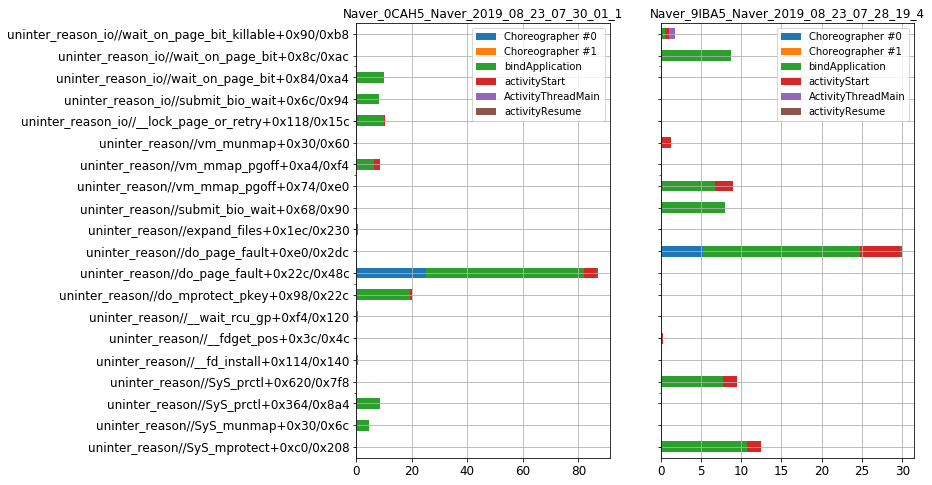

In [26]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

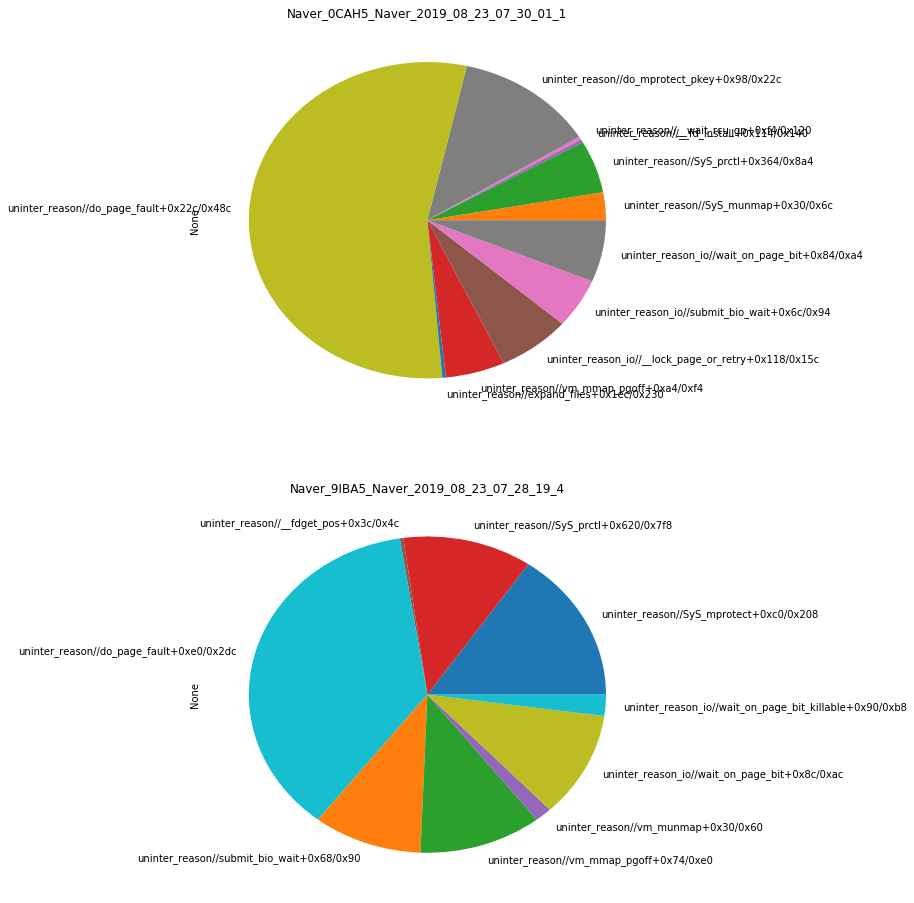

In [27]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

The number of count in each reason of uninterruptible sleep.

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

In [28]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [29]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  \
Naver_0CAH5_Naver_2019_08_23_07_30_01_1 core0                 6   
                                        core1                37   
                                        core2                 2   
                                        core3                30   
                                        core4               249   
                                        core5               192   
                                        core6                83   
                                        core7                99   
Naver_9IBA5_Naver_2019_08_23_07_28_19_4 core0                12   
                                        core1                12   
                                        core2                 3   
                                        core3                 3   
                                        core4               674   
                                        core5               278   
                                        core6                89   
                                        core7                90   

                                               Choreographer #1  \
Naver_0CAH5_Naver_2019_08_23_07_30_01_1 core0                 0   
                                        core1                 0   
                                        core2                 0   
                                        core3                 0   
                                        core4                 3   
                                        core5                 3   
                                        core6                 5   
                                        core7                 1   
Naver_9IBA5_Naver_2019_08_23_07_28_19_4 core0                 1   
                                        core1                 0   
                                        core2                 0   
                                        core3                 0   
                                        core4                 5   
                                        core5                16   
                                        core6                 0   
                                        core7                 5   

                                               bindApplication  activityStart  \
Naver_0CAH5_Naver_2019_08_23_07_30_01_1 core0               63              1   
                                        core1               23              3   
                                        core2               13              0   
                                        core3                7              0   
                                        core4               90             89   
                                        core5              226             78   
                                        core6              125             35   
                                        core7               93             23   
Naver_9IBA5_Naver_2019_08_23_07_28_19_4 core0               37              7   
                                        core1               44             10   
                                        core2               17             13   
                                        core3               16             28   
                                        core4              428            253   
                                        core5              233             83   
                                        core6              172             64   
                                        core7              150             69   

                                               ActivityThreadMain  \
Naver_0CAH5_Naver_2019_08_23_07_30_01_1 core0                   1   
                                        core1                   0   
                                        core2                   0   
                                        core3                   0   
                                        core

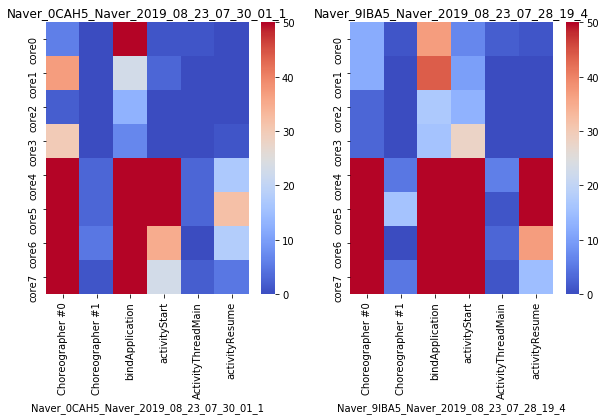

In [30]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [31]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

Clock_10HAZFRE9_Alarm2


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,6,0,NaN,10,NaN,NaN,NaN
core1,NaN,1,0,NaN,4,NaN,NaN,NaN
core2,NaN,3,0,NaN,1,NaN,NaN,NaN
core3,NaN,0,0,NaN,3,NaN,NaN,NaN
core4,NaN,56,7,NaN,13,NaN,NaN,NaN
core5,NaN,27,1,NaN,1,NaN,NaN,NaN
core6,NaN,17,2,NaN,12,NaN,NaN,NaN
core7,NaN,11,0,NaN,5,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,10,0,NaN,NaN
core1,NaN,0,0,0,2,0,NaN,NaN
core2,NaN,0,0,0,1,1,NaN,NaN
core3,NaN,0,0,0,4,0,NaN,NaN
core4,NaN,14,0,44,35,6,NaN,NaN
core5,NaN,27,0,21,30,1,NaN,NaN
core6,NaN,29,0,0,21,0,NaN,NaN
core7,NaN,24,6,0,33,0,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,6,0,NaN,3,NaN,NaN,NaN
core1,NaN,3,0,NaN,3,NaN,NaN,NaN
core2,NaN,7,0,NaN,2,NaN,NaN,NaN
core3,NaN,2,0,NaN,4,NaN,NaN,NaN
core4,NaN,54,5,NaN,15,NaN,NaN,NaN
core5,NaN,32,0,NaN,10,NaN,NaN,NaN
core6,NaN,16,2,NaN,12,NaN,NaN,NaN
core7,NaN,17,2,NaN,3,NaN,NaN,NaN


In [32]:
print(group2.title)
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

Clock_1BZGFSH9_c_lock2


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,0,NaN,0,NaN,2,NaN
core1,NaN,0,0,NaN,1,NaN,0,NaN
core2,NaN,1,0,NaN,1,NaN,4,NaN
core3,NaN,0,0,NaN,10,NaN,1,NaN
core4,NaN,2,0,NaN,0,NaN,0,NaN
core5,NaN,11,2,NaN,1,NaN,0,NaN
core6,NaN,8,1,NaN,17,NaN,8,NaN
core7,NaN,3,0,NaN,1,NaN,1,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,2,1,NaN,0,NaN,1,NaN
core1,NaN,0,0,NaN,1,NaN,1,NaN
core2,NaN,0,0,NaN,1,NaN,6,NaN
core3,NaN,0,0,NaN,0,NaN,0,NaN
core4,NaN,4,0,NaN,8,NaN,2,NaN
core5,NaN,11,2,NaN,0,NaN,4,NaN
core6,NaN,7,0,NaN,18,NaN,2,NaN
core7,NaN,2,0,NaN,2,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,2,0,2,3,0,1,NaN
core1,NaN,0,1,8,6,0,0,NaN
core2,NaN,0,0,0,0,0,0,NaN
core3,NaN,0,0,2,1,0,0,NaN
core4,NaN,24,0,16,41,4,6,NaN
core5,NaN,3,0,3,31,1,10,NaN
core6,NaN,7,3,2,28,0,6,NaN
core7,NaN,12,0,23,15,0,0,NaN


In [33]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [34]:
print(group1.title)
display(GetCoreStats(group1))

Clock_10HAZFRE9_Alarm2


0  1  2  3  4  5  6  7  selected        time
activityStart    0    I  R  R  V  I  I  I  R         3  623.504747
                 1    I  I  I  I  V  I  I  R         4  623.505937
                 2    I  I  I  V  I  I  I  R         3  623.506494
                 3    R  V  I  I  I  I  R  R         1  623.508781
                 4    R  I  I  R  R  V  I  R         5  623.509497
                 5    R  V  I  R  I  I  R  R         1  623.509775
                 6    V  R  I  I  I  I  I  R         0  623.511573
                 7    R  I  I  I  R  I  V  R         6  623.521900
                 8    R  I  I  I  I  R  V  R         6  623.527106
                 9    R  I  I  I  I  I  V  I         6  623.527607
                 10   I  R  I  I  I  I  V  I         6  623.528379
                 11   R  I  I  I  R  I  V  I         6  623.529004
                 12   I  I  I  I  R  V  I  I         5  623.540510
                 13   I  I  I  I  R  V  I  I         5  623.541176
                 14   I  I  I  I  I  V  R  R         5  623.542345
                 15   R  I  I  I  R  I  I  V         7  623.555130
                 16   V  I  I  I  I  I  I  R         0  623.570070
                 17   I  I  I  I  I  V  I  I         5  623.570114
                 18   I  I  V  I  I  I  I  I         2  623.574725
                 19   I  I  I  I  I  V  I  I         5  623.574970
                 20   R  I  R  I  I  I  V  R         6  623.575822
                 21   I  I  I  R  I  V  R  R         5  623.577546
                 22   R  R  I  R  I  I  R  V         7  623.578171
                 23   R  I  I  V  R  I  I  R         3  623.578430
                 24   R  I  I  I  R  V  I  R         5  623.578514
                 25   R  R  I  I  R  I  V  R         6  623.578698
                 26   R  I  I  I  R  V  R  I         5  623.578842
                 27   I  I  I  I  I  V  I  I         5  623.582955
                 28   I  I  I  I  I  R  V  I         6  623.583363
                 29   I  I  I  I  I  R  V  I         6  623.584706
                 30   I  I  I  I  I  R  V  R         6  623.585194
                 31   I  I  I  I  I  R  V  I         6  623.585605
                 32   I  I  I  I  I  R  V  I         6  623.586478
                 33   I  I  I  I  V  R  R  I         4  623.587720
                 34   I  I  I  I  V  R  R  I         4  623.588489
                 35   I  I  I  I  V  R  I  I         4  623.589260
                 36   I  I  I  I  V  R  I  R         4  623.590229
                 37   I  I  I  I  V  R  I  I         4  623.590629
                 38   I  I  I  I  V  R  I  I         4  623.590812
                 39   I  I  R  I  V  R  I  I         4  623.591343
                 40   I  I  V  I  I  R  I  I         2  623.591724
                 41   I  I  I  I  V  R  I  I         4  623.591803
                 42   I  I  I  I  V  R  I  R         4  623.592241
                 43   R  I  I  I  V  R  I  I         4  623.592297
                 44   R  V  I  I  R  R  I  R         1  623.592476
                 45   V  I  I  R  I  I  I  I         0  623.594099
                 46   I  R  I  I  R  I  I  V         7  623.594961
                 47   I  R  I  R  V  I  I  R         4  623.597307
                 48   I  I  R  V  I  R  R  R         3  623.598426
                 49   I  I  I  I  V  I  I  R         4  623.598735
                 50   I  I  I  I  V  I  I  R         4  623.598923
                 51   I  I  I  I  V  I  I  R         4  623.599496
Choreographer #0 0    I  R  I  R  R  I  I  V         7  623.610560
                 1    R  I  I  V  R  R  R  I         3  623.613305
                 2    V  I  I  I  I  I  I  I         0  623.616470
                 3    V  I  I  I  I  I  I  I         0  623.616782
                 4    I  I  I  I  I  I  I  V         7  623.616954
                 5    R  I  V  R  R  R  I  I         2  623.627363
                 6    V  I  I  I  R  I  I  R         0  623.628256
  

In [35]:
print(group2.title)
display(GetCoreStats(group2))

Clock_1BZGFSH9_c_lock2


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  I  I  R  V  I  I  I         4  367.898386
                   1    I  I  I  I  I  V  I  I         5  367.899543
                   2    I  I  R  R  V  R  I  R         4  367.900620
                   3    I  I  I  I  V  I  I  I         4  367.902068
                   4    I  I  I  R  R  V  I  I         5  367.963816
bindApplication    0    I  V  I  I  I  I  I  R         1  367.967266
                   1    I  V  I  I  R  I  I  I         1  367.968310
                   2    I  V  I  I  R  I  I  I         1  367.968812
                   3    I  V  I  I  R  I  R  R         1  367.976754
                   4    R  V  R  I  R  I  I  R         1  367.977516
                   5    I  V  I  I  I  R  I  I         1  367.985756
                   6    I  V  I  R  I  I  I  I         1  367.985833
                   7    V  I  I  R  I  R  I  R         0  367.997712
                   8    R  I  I  V  I  I  I  I         3  368.001165
                   9    I  I  I  R  I  I  I  V         7  368.001655
                   10   V  I  I  I  I  I  I  R         0  368.001846
                   11   I  I  I  I  I  I  I  V         7  368.002191
                   12   R  I  I  I  I  I  I  V         7  368.002305
                   13   I  I  I  I  I  R  I  V         7  368.006895
                   14   I  I  I  I  I  I  R  V         7  368.019460
                   15   I  I  I  I  I  I  R  V         7  368.021325
                   16   I  I  I  I  I  I  I  V         7  368.022123
                   17   I  I  I  I  I  I  I  V         7  368.022716
                   18   R  I  I  I  I  V  I  I         5  368.023404
                   19   R  R  I  I  I  I  I  V         7  368.024050
                   20   I  R  I  I  I  I  I  V         7  368.024939
                   21   I  R  I  I  I  I  R  V         7  368.026191
                   22   I  R  I  I  I  R  V  I         6  368.031886
                   23   I  R  I  I  I  R  I  V         7  368.032121
                   24   I  R  I  I  I  R  V  I         6  368.032338
                   25   I  I  R  I  I  I  I  V         7  368.032690
                   26   I  R  I  R  V  R  I  I         4  368.053614
                   27   I  I  I  I  V  I  I  I         4  368.057885
                   28   I  I  I  I  V  I  I  I         4  368.058651
                   29   I  I  I  I  V  I  I  I         4  368.059250
                   30   R  I  I  I  V  I  R  R         4  368.060219
                   31   I  I  R  I  V  I  R  I         4  368.066823
                   32   I  R  I  I  I  R  I  V         7  368.067789
                   33   I  I  I  I  V  R  I  I         4  368.075370
                   34   I  I  R  I  I  I  R  V         7  368.084138
                   35   R  I  R  R  V  R  I  I         4  368.086874
                   36   I  I  I  I  V  I  I  I         4  368.088990
                   37   I  I  I  I  I  V  I  I         5  368.090104
                   38   I  I  I  I  V  I  I  I         4  368.090521
                   39   I  I  I  I  V  I  I  I         4  368.091264
                   40   I  I  I  I  I  R  R  V         7  368.092719
                   41   I  I  I  I  R  I  I  V         7  368.094269
                   42   I  I  I  I  R  I  I  V         7  368.094409
                   43   I  I  I  I  R  I  I  V         7  368.094590
                   44   I  I  I  I  R  I  I  V         7  368.094674
                   45   I  I  I  I  V  I  I  I         4  368.095620
                   46   I  I  I  I  I  R  I  V         7  368.096320
                   47   I  I  I  I  I  I  I  V         7  368.097300
                   48   I  V  R  I  R  I  R  I         1  368.098101
                   49   I  I  R  V  R  I  R  I         3  368.098164
                   50   I  I  R  I  V  I  I  R         4  368.099281
                   51   R  I  I  R  V  I  I  R         4  368.099401
                   52 

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [36]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

Clock_10HAZFRE9_Alarm2


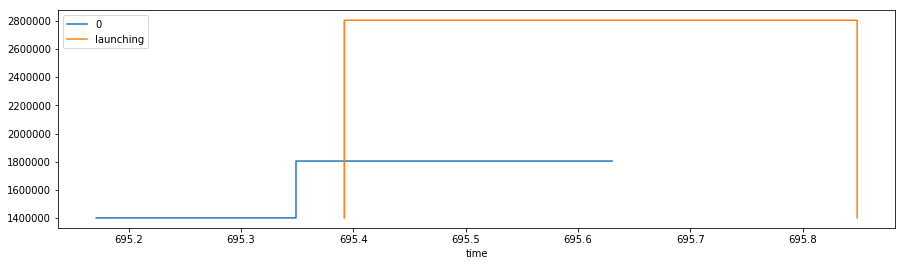

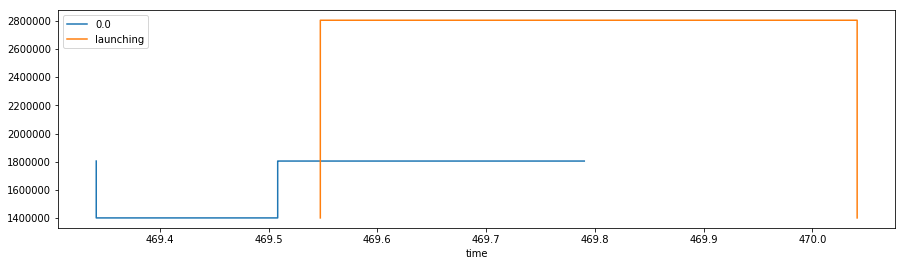

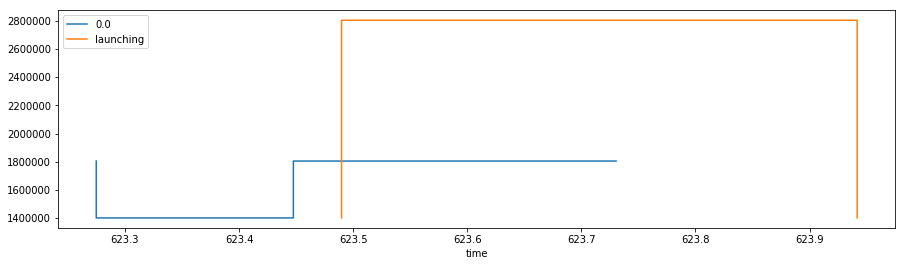

In [37]:
print(group1.title)
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

Clock_1BZGFSH9_c_lock2


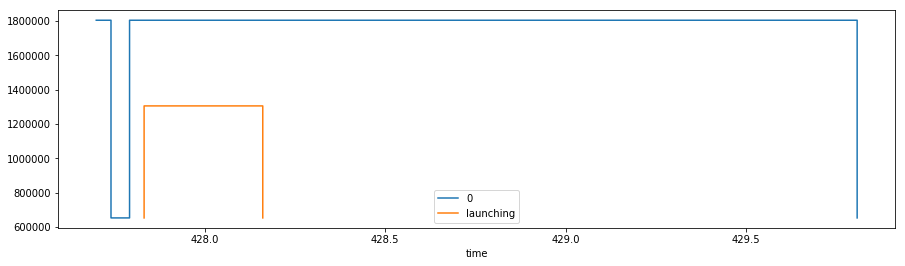

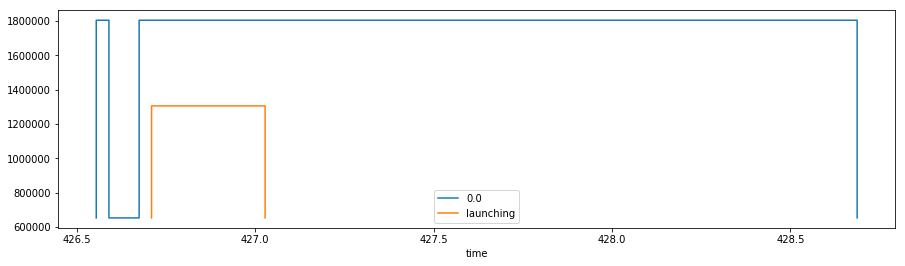

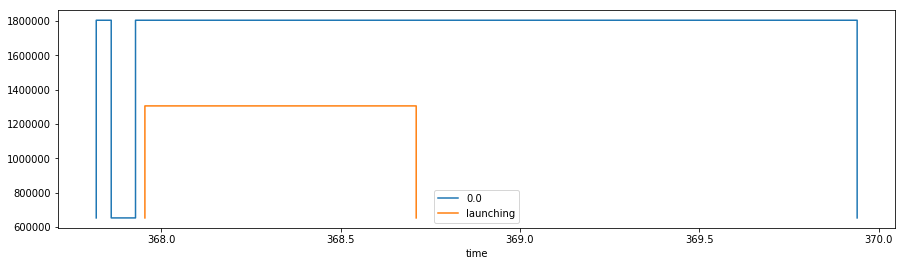

In [38]:
print(group2.title)
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [39]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

Clock_10HAZFRE9_Alarm2


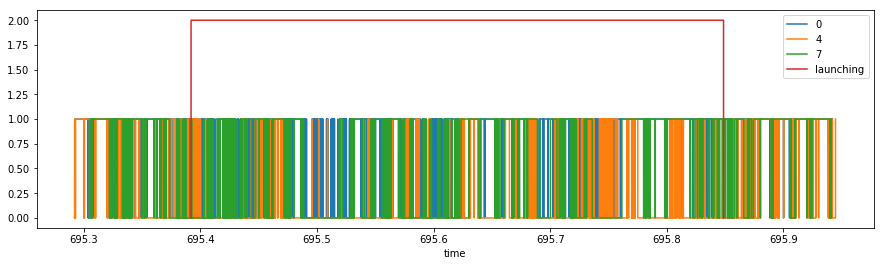

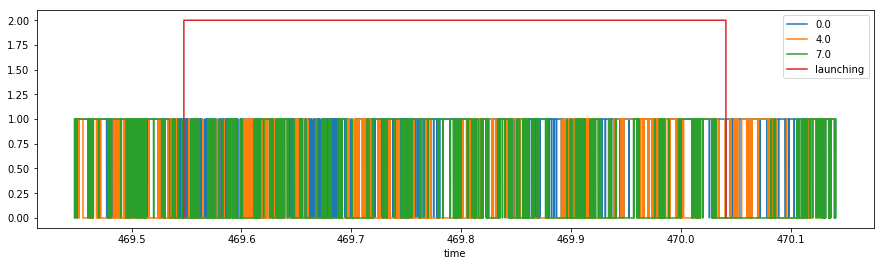

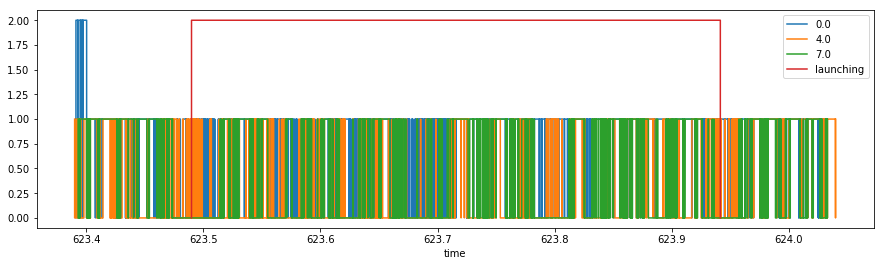

In [40]:
print(group1.title)
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

Clock_1BZGFSH9_c_lock2


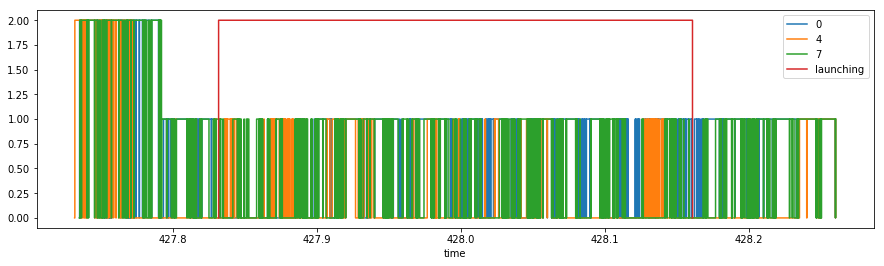

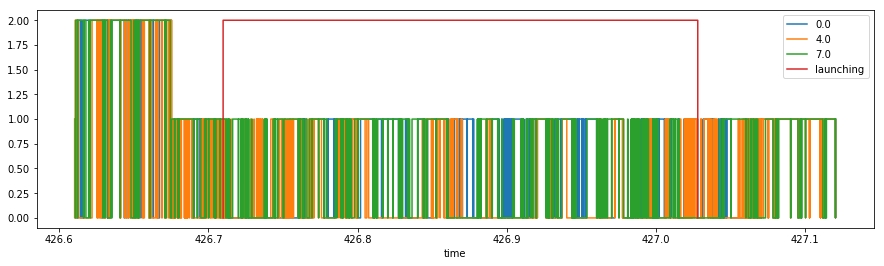

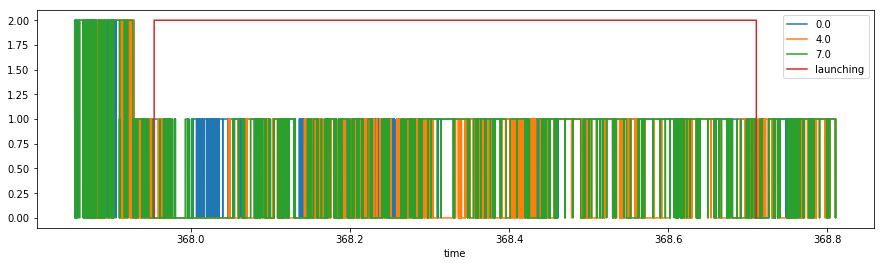

In [41]:
print(group2.title)
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [42]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [43]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
Clock_10HAZFRE9_Alarm2,lock_contention,0,25.591,3.037,0,33.912,0,0.000,0
Clock_1BZGFSH9_c_lock2,lock_contention,0,10.712,3.517,0,18.552,0,0.101,0
DIFF,lock_contention,0,14.879,-0.480,0,15.360,0,-0.101,0


In [44]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [45]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'Clock_10HAZFRE9_Alarm2'

,blocking,context,duration,effection,owner,pid,time,type
31,void com.android.server.am.ActivityMetricsLog...,monitor contention with owner Binder:1451_2 (1...,36.277,O,Binder:1451_2 (1472) at void com.android.serve...,1508,695.392434,B
29,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1451_2 (1...,36.229,O,Binder:1451_2 (1472) at void com.android.serve...,3340,695.392347,B
33,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1451_2 (1...,33.357,O,Binder:1451_2 (1472) at void com.android.serve...,1509,695.395999,B
34,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:1451_2 (1...,30.597,O,Binder:1451_2 (1472) at void com.android.serve...,4346,695.399002,B
42,boolean com.android.server.am.ActivityManager...,monitor contention with owner Binder:1451_2 (1...,14.955,O,Binder:1451_2 (1472) at void com.android.serve...,2378,695.414766,B
115,void com.android.server.wm.WindowAnimator.lam...,monitor contention with owner Binder:1451_13 (...,11.964,O,Binder:1451_13 (4346) at int com.android.serve...,1754,695.706122,B
84,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:1451_13 (...,11.859,O,Binder:1451_13 (4346) at android.app.ActivityM...,3240,695.446600,B
85,void com.android.server.am.ActivityRecord.onS...,monitor contention with owner Binder:1451_13 (...,11.833,O,Binder:1451_13 (4346) at android.app.ActivityM...,1550,695.446723,B
86,java.util.List com.android.server.am.Activity...,monitor contention with owner Binder:1451_13 (...,11.774,O,Binder:1451_13 (4346) at android.app.ActivityM...,1509,695.446863,B
114,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1451_13 (...,11.450,O,Binder:1451_13 (4346) at int com.android.serve...,1550,695.705989,B


In [46]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'Clock_1BZGFSH9_c_lock2'

,blocking,context,duration,effection,owner,pid,time,type
29,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (14...,27.392,O,android.anim (1489) at void com.android.server...,1438,427.863102,B
28,int com.android.server.wm.WindowManagerServic...,monitor contention with owner android.anim (14...,21.010,O,android.anim (1489) at void com.android.server...,5520,427.862807,B
30,void com.android.server.wm.TaskWindowContaine...,monitor contention with owner android.anim (14...,17.680,O,android.anim (1489) at void com.android.server...,3176,427.872911,B
53,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (14...,17.349,O,android.anim (1489) at void com.android.server...,1438,428.137264,B
54,void com.android.server.wm.WindowSurfacePlace...,monitor contention with owner Binder:1380_E (3...,16.668,O,Binder:1380_E (3176) at void com.android.serve...,1489,428.138077,B
31,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:1380_E (3...,15.647,O,Binder:1380_E (3176) at void com.android.serve...,2111,427.875209,B
16,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:1380_12 (...,12.219,O,Binder:1380_12 (5520) at void com.android.serv...,3176,427.849547,B
32,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (14...,12.082,O,android.anim (1489) at void com.android.server...,3143,427.878579,B
10,void com.android.server.wm.AppWindowContainer...,monitor contention with owner android.anim (14...,8.824,O,android.anim (1489) at int com.android.server....,5520,427.832142,B
43,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1380_D (3...,8.364,O,Binder:1380_D (3143) at int com.android.server...,1438,428.032088,B


In [47]:
display(group1.title)
display(df1['duration'].sum())

u'Clock_10HAZFRE9_Alarm2'

327.99099999999726

In [48]:
display(group2.title)
display(df2['duration'].sum())

u'Clock_1BZGFSH9_c_lock2'

203.88100000002396

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [49]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'Clock_10HAZFRE9_Alarm2'

,owner
Binder:1451_2 (1472) at void com.android.server.am.ActivityManagerService.activityPaused(android.os.IBinder)(ActivityManagerService.java:9725),6
android.display (1550) at void com.android.server.wm.WindowManagerService$H.handleMessage(android.os.Message)(WindowManagerService.java:6142),5
android.anim (1754) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:161),5
Binder:1451_13 (4346) at android.app.ActivityManager$StackInfo com.android.server.am.ActivityManagerService.getStackInfo(int)(ActivityManagerService.java:14172),4
Binder:1451_2 (1472) at boolean com.android.server.wm.WindowManagerService.containsDismissKeyguardWindow(android.os.IBinder)(WindowManagerService.java:3658),4
"Binder:1451_D (2378) at boolean com.android.server.am.ActivityManagerService.stopServiceToken(android.content.ComponentName, android.os.IBinder, int)(ActivityManagerService.java:22738)",3
Binder:1451_13 (4346) at void com.android.server.am.ActivityManagerService.trimApplications()(ActivityManagerService.java:28180),3
"Binder:1451_D (2378) at void com.android.server.am.ActivityManagerService.setTaskDescription(android.os.IBinder, android.app.ActivityManager$TaskDescription)(ActivityManagerService.java:13251)",3
"android.anim (1754) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF)(WindowManagerService.java:2280)",3
"Binder:1451_13 (4346) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF)(WindowManagerService.java:2280)",3


In [50]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'Clock_1BZGFSH9_c_lock2'

,owner
android.anim (1489) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:153),6
android.anim (1489) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0(com.android.server.wm.WindowSurfacePlacer)(WindowSurfacePlacer.java:122),4
Binder:1380_12 (5520) at void com.android.server.am.ActivityManagerService.activityPaused(android.os.IBinder)(ActivityManagerService.java:10726),3
"Binder:1380_E (3176) at void com.android.server.am.ActivityManagerService.setTaskDescription(android.os.IBinder, android.app.ActivityManager$TaskDescription)(ActivityManagerService.java:14153)",2
"android.anim (1489) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF, com.samsung.android.view.ConventionalModeBar$Info)(WindowManagerService.java:2232)",2
"android.ui (1428) at java.util.List com.android.server.am.ActivityManagerService.getFilteredTasks(int, int, int)(ActivityManagerService.java:13994)",2
FgCheckThread (1869) at java.util.List com.android.server.am.ActivityManagerService.getRunningAppProcesses()(ActivityManagerService.java:20434),2
"Binder:1380_12 (5520) at void com.android.server.wm.WindowManagerService.setFocusedApp(android.os.IBinder, boolean)(WindowManagerService.java:3104)",2
Binder:1380_D (3143) at android.app.ActivityManager$StackInfo com.android.server.am.ActivityManagerService.getFocusedStackInfo()(ActivityManagerService.java:27419),1
Binder:1380_6 (2111) at int com.android.server.am.ActivityManagerService.getLastResumedActivityUserId()(ActivityManagerService.java:32942),1


Text(0,0.5,'weight')

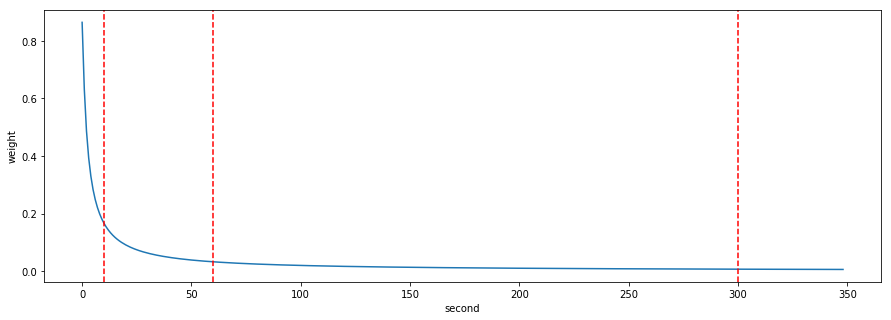

In [51]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')